In [139]:
# -*- encoding:utf-8 -*-
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)
# import warnings; 
# warnings.filterwarnings('ignore')

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
#sys.setdefaultencoding('utf-8')
import abupy



## 1. 3D 选股策略
### 1.1.1 CurveProjection 

In [140]:
from abupy import AbuFactorSellKDJ
from abupy import AbuFactorSellCurveProjection
from abupy import AbuFactorAtrNStop
from abupy import AbuFactorPreAtrNStop
from abupy import AbuFactorCloseAtrNStop
from abupy import AbuBenchmark
from abupy import AbuPickTimeWorker
from abupy import AbuCapital
from abupy import AbuKLManager
from abupy import ABuTradeProxy
from abupy import ABuTradeExecute
from abupy import ABuPickTimeExecute
from abupy import AbuMetricsBase
from abupy import ABuMarket
from abupy import AbuPickTimeMaster
from abupy import ABuRegUtil
from abupy import AbuPickRegressAngMinMax
from abupy import AbuPickStockWorker
from abupy import ABuPickStockExecute
from abupy import AbuPickStockPriceMinMax
from abupy import AbuPickStockMaster

from abupy import AbuPickKDJ
from abupy import AbuFactorBuyKDJ

from abupy import EMarketDataFetchMode
from abupy import EMarketSourceType
from abupy import EMarketTargetType
from abupy import EDataCacheType
from abupy import ABuDateUtil




In [141]:
def init_env():
    #环境
    abupy.env.disable_example_env_ipython()
    #abupy.env.g_market_source = EMarketSourceType.E_MARKET_SOURCE_nt
    abupy.env.g_market_source = EMarketSourceType.E_MARKET_SOURCE_tdx_db

    abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
    abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_CSV

    #abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL
    #abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_NORMAL
    abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET
    
init_env()

disable example env


In [142]:
    #buy factors
    buy_factors = [{'class': AbuFactorBuyKDJ, 
        'ma_period': 10,
        'k_threshold':60, 
        'd_threshold':60, 
        'j_threshold':0,
        'mfi_threshold':50,
        'debug':True}]

    #sell factors

    sell_factor1 = {'class': AbuFactorSellCurveProjection,
        'mfi_threshold':85,
        'k_threshold':50,
        'd_threshold':50,
        'j_threshold':90,
        'mfi_threshold':70,
        'debug':True
        }
    sell_factors = [sell_factor1]
    #A股，永不可能，相当于不丢弃单子，这里缺省使用的均值滑点
    abupy.slippage.sbm.g_open_down_rate = 0.11
    #仓位控制 100%
    abupy.beta.position.g_pos_max = 1.0
    #系统缺省使用了atr仓位控制器
    abupy.beta.atr.g_atr_pos_base = 1.0

In [143]:
    #benchmark = AbuBenchmark()
    benchmark = AbuBenchmark(n_folds = 2)
    #benchmark = AbuBenchmark(start = "20161121", end="20161122")
    capital = AbuCapital(100000, benchmark)
    kl_pd_manager = AbuKLManager(benchmark, capital)
    
    # 获取symbol的交易数据
    #symbol = '002236' #大华股份
    #symbol = '000002'
    #symbol = '601939' #建设银行
    symbol = '600080'
    #symbol = '601398' #工商银行
    #symbol = '601319'  #few datas
    kl_pd = kl_pd_manager.get_pick_time_kl_pd(symbol)    

In [144]:
    abu_worker = AbuPickTimeWorker(capital, kl_pd, benchmark, buy_factors, sell_factors)
    abu_worker.fit()

牛熊线数据:
开始日期   结束日期     开始价格   结束价格    角 度     步长    斜率验证
2016-12-12 2017-03-13   11.960      11.770       0.000     59
2017-03-13 2017-07-12   11.770      10.340       0.000     82
2017-07-12 2017-11-06   10.340      11.160       0.000     78
2017-11-06 2018-03-05   11.160      9.080       0.000     79
2018-03-05 2018-11-02   9.080      10.000       0.000     163
2018-11-02 2018-12-03   10.000      10.150       0.000     21
2018-12-03 2018-12-10   10.150      8.440       0.000     5
symbol 's ma(10) is sliced in 21 slices
均线切片数据:
开始日期   结束日期     开始价格   结束价格    角 度     步长    斜率验证
2016-12-12 2017-01-10   11.960      12.810       50.240     021      25.241
2017-01-11 2017-01-26   12.700      11.730      -6.380     012      11.328
2017-02-03 2017-03-07   11.690      12.040       1.023     023      11.943
2017-03-08 2017-06-08   12.030      9.310      -3.106     062      8.633
2017-06-09 2017-06-27   9.240      9.790       3.462     013      10.035
2017-06-28 2017-08-03   9.980      10.660 

In [145]:
    factor = abu_worker.buy_factors[0]
    mean_split = factor.mean_split
    factor_summary = list()
    factor_summary.append(mean_split._peaks)
    factor_summary.append(mean_split._bear_bull_peaks)
    factor_summary.append(mean_split._slices)
    factor_summary.append(mean_split._degs)
    factor_summary.append(mean_split._steps)
    
    factor._param_pd

,KDJ_D,KDJ_J,KDJ_K,MFI
2016-12-12,0.0000,0.0000,0.0000,NaN
2016-12-13,0.0000,0.0000,0.0000,NaN
2016-12-14,0.0000,0.0000,0.0000,NaN
2016-12-15,0.0000,0.0000,0.0000,NaN
2016-12-16,0.0000,0.0000,0.0000,NaN
2016-12-19,0.0000,0.0000,0.0000,NaN
2016-12-20,0.0000,0.0000,0.0000,NaN
2016-12-21,0.0000,0.0000,0.0000,NaN
2016-12-22,5.6980,39.8860,17.0940,NaN
2016-12-23,10.7719,41.2156,20.9198,NaN


In [146]:
from mpl_toolkits.mplot3d import Axes3D

length = len(factor._param_pd['KDJ_J'].values)
x = np.arange(length)
kl_pd

,open,close,high,low,volume,date,pre_close,date_week,p_change,atr21,atr14,key,ma_bear_bull,ma,week_task,month_task
2016-12-12,12.91,11.96,12.91,11.75,6.2950e+06,20161212,12.88,0,-7.143,1.1600,1.1600,0,0.0000,0.000,0,0
2016-12-13,11.94,11.98,12.12,11.75,3.8697e+06,20161213,11.96,1,0.167,1.1443,1.1439,1,0.0000,0.000,0,0
2016-12-14,11.96,11.89,12.06,11.88,3.3576e+06,20161214,11.98,2,-0.751,0.7918,0.7757,2,0.0000,0.000,0,0
2016-12-15,11.74,12.14,12.50,11.74,4.5830e+06,20161215,11.89,3,2.103,0.7827,0.7709,3,0.0000,0.000,0,0
2016-12-16,12.11,12.43,12.48,12.11,4.2098e+06,20161216,12.14,4,2.389,0.7365,0.7237,4,0.0000,0.000,1,0
2016-12-19,12.43,12.63,12.79,12.39,5.7846e+06,20161219,12.43,0,1.609,0.7184,0.7066,5,0.0000,0.000,0,0
2016-12-20,12.45,12.49,12.52,12.24,3.9324e+06,20161220,12.63,1,-1.108,0.6365,0.6167,6,0.0000,0.000,0,0
2016-12-21,12.46,12.28,12.58,12.15,4.9265e+06,20161221,12.49,2,-1.681,0.6099,0.5900,7,0.0000,0.000,0,0
2016-12-22,12.31,12.34,12.39,12.19,2.8430e+06,20161222,12.28,3,0.489,0.5610,0.5366,8,0.0000,0.000,0,0
2016-12-23,12.37,12.04,12.47,12.02,4.0058e+06,20161223,12.34,4,-2.431,0.5445,0.5214,9,0.0000,12.218,1,0


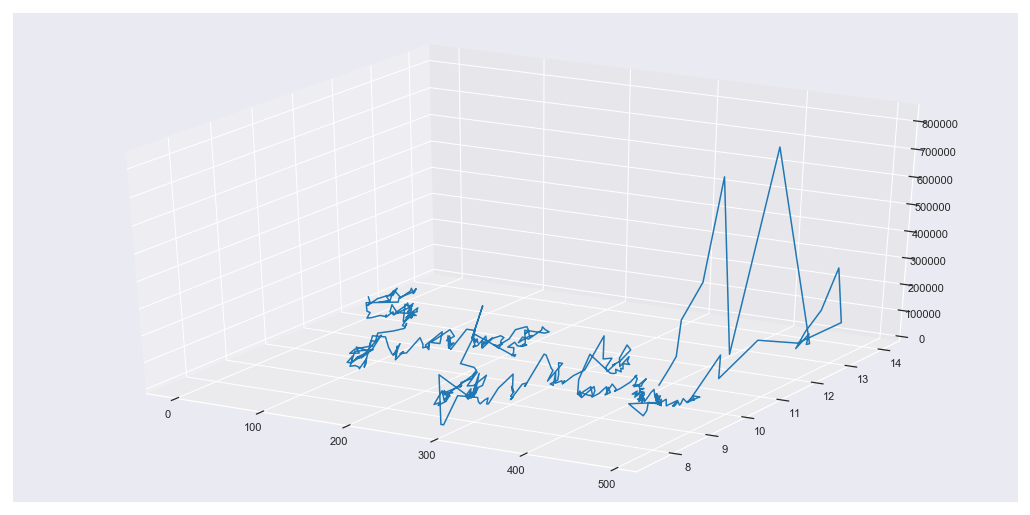

In [147]:
#价/量 平面投影

y = kl_pd.close.values
z = (kl_pd.volume.values) / 100
fig = plt.figure(figsize=(18,9))
ax = fig.gca(projection='3d')

#x = np.zeros(length)
#y = np.zeros(length)
#z = np.zeros(length)

ax.plot(x, y, z, label='price/count')

"""
x1 = x[-20:]
y1 = y[-20:]
z1 = z[-20:]
ax.plot(x1, y1, z1, label='price/count')
#ax.plot(x, y, z, label='price/count')
"""
x1 = x[-100:]
y1 = y[-100:]
z1 = z[-100:]

#ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
#ax.plot_trisurf(x1, y1, z1, linewidth=0.2, antialiased=True)
#ax.legend()
plt.show()

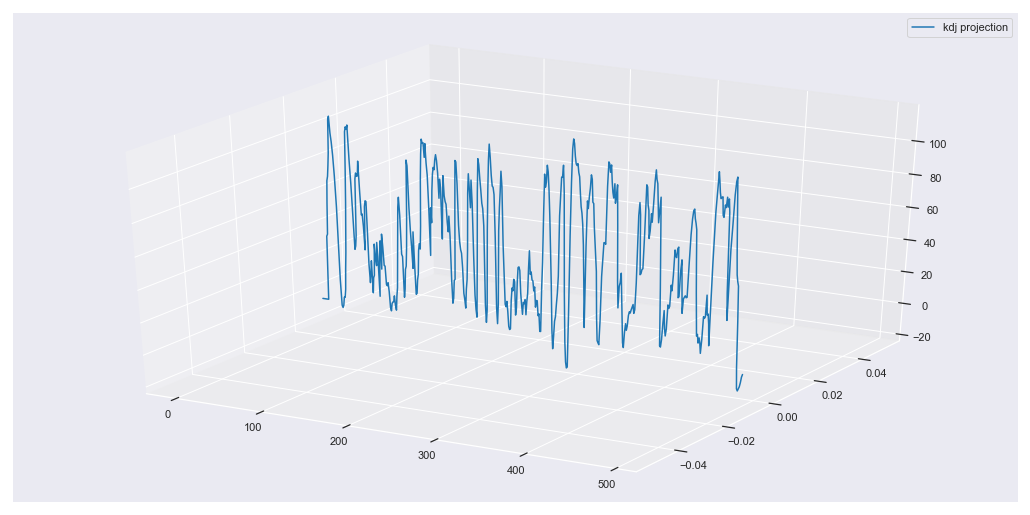

In [148]:
#kdj 平面投影
z = factor._param_pd['KDJ_J'].values
y = np.zeros(length)
fig = plt.figure(figsize=(18,9))
ax = fig.gca(projection='3d')

ax.plot(x, y, z, label='kdj projection')
ax.legend()
plt.show()

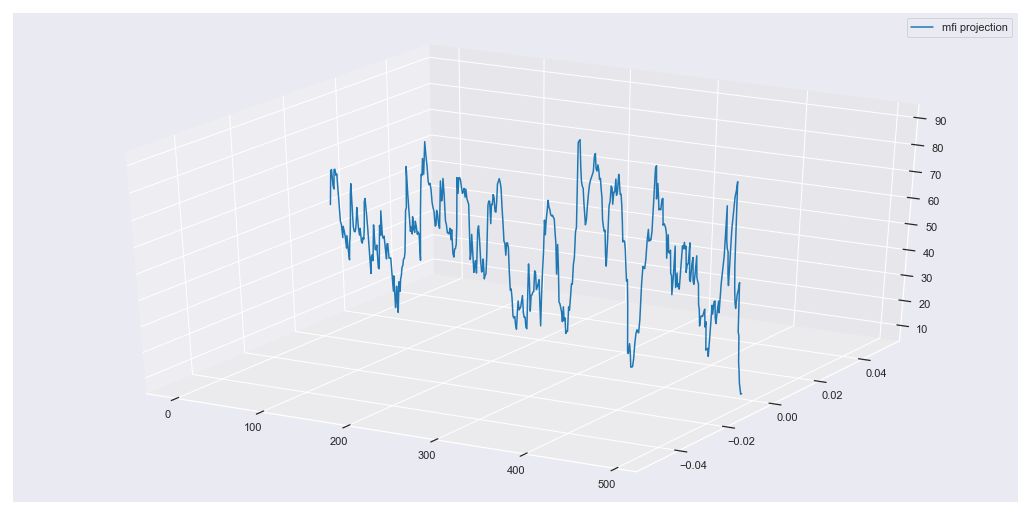

In [149]:
#mfi 平面投影
z = factor._param_pd['MFI'].values
y = np.zeros(length)
fig = plt.figure(figsize=(18,9))
ax = fig.gca(projection='3d')

ax.plot(x, y, z, label='mfi projection')
ax.legend()
plt.show()


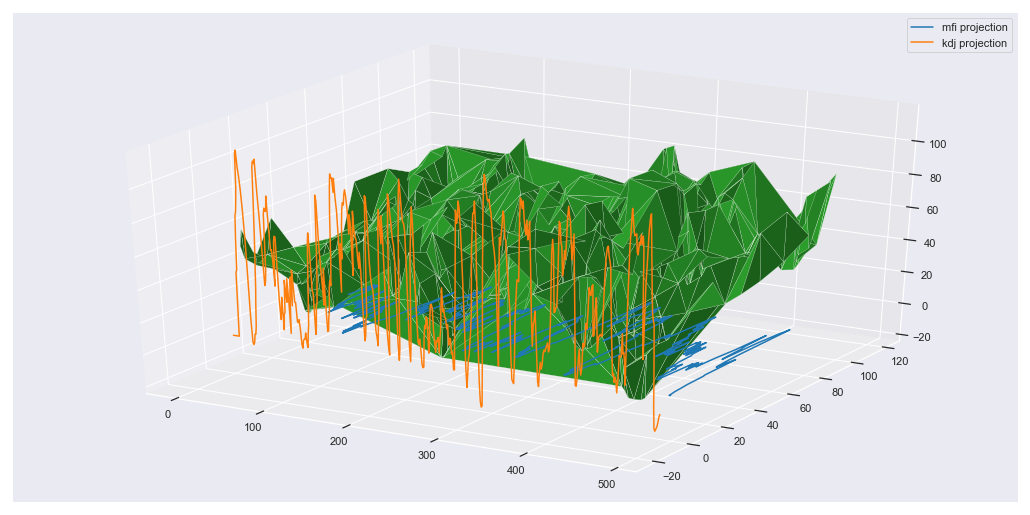

In [164]:
#curve projection
y = factor._param_pd['KDJ_J'].values
z = factor._param_pd['MFI'].values
k = kl_pd.close.values * 8

fig = plt.figure(figsize=(18,9))
ax = fig.gca(projection='3d')

from matplotlib import cm


"""
x1 = x[-100:]
y1 = y[-100:]
z1 = z[-100:]

k1 = k[-100:]

y2 = np.zeros(len(y1))
ax.plot(x1, z1, y2, label='mfi projection')

z2 = np.zeros(len(z1))
ax.plot(x1, z2, y1, label='kdj projection')
ax.plot(x1, z2, k1, label='close projection')

ax.plot_trisurf(x1, y1, z1, linewidth=0.2, antialiased=True)

"""



z2 = np.zeros(len(z))
ax.plot(x, z, z2, label='mfi projection')

y2 = np.zeros(len(y))
ax.plot(x, y2, y, label='kdj projection')
#ax.plot(x, y2, k, label='close projection')



ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
ax.legend()

plt.show()



TypeError: Length of y must be number of rows in z.

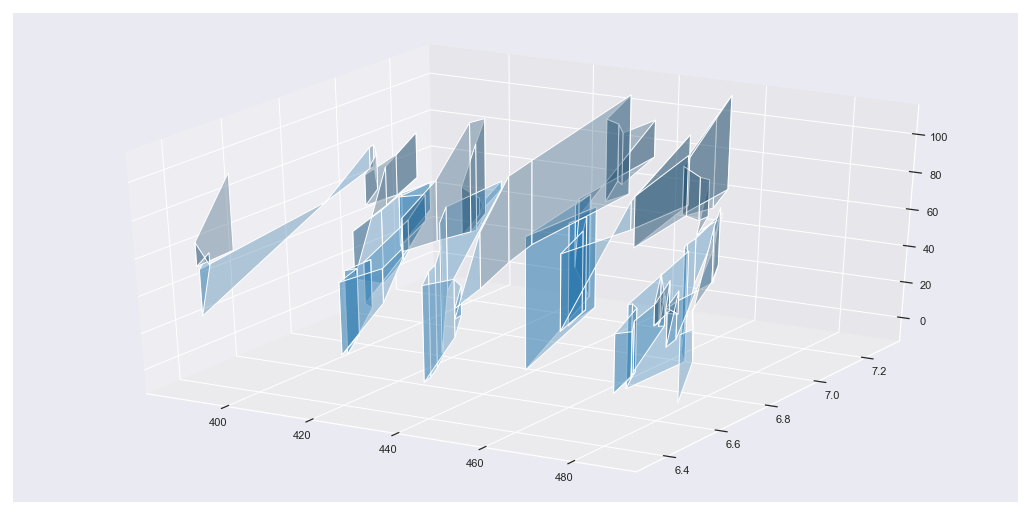

In [132]:
#curve projection
z1 = factor._param_pd['KDJ_J'].values
z2 = factor._param_pd['MFI'].values
y = kl_pd.close.values

fig = plt.figure(figsize=(18,9))
ax = fig.gca(projection='3d')

z = np.array([z1, z2])


#ax.plot_wireframe(x, y, z, rstride=1, cstride=1, label='curve projection')
#ax.legend()


x1 = x[-100:]
y1 = y[-100:]
z3 = np.array([z1[-100:], z2[-100:]])

ax.plot_surface(x1, y1, z3, rstride=1, cstride=1, alpha=0.3)

cset = ax.contour(x1, y1, z3, zdir='z', offset=0, cmap=cm.coolwarm)
cset = ax.contour(x1, y1, z3, zdir='x', offset=0, cmap=cm.coolwarm)
cset = ax.contour(x1, y1, z3, zdir='y', offset=0, cmap=cm.coolwarm)
 
plt.show()


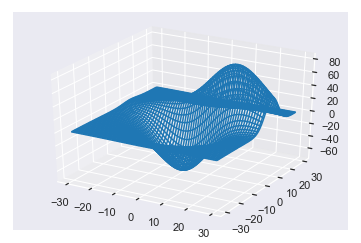

In [120]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

def get_test_data(delta=0.05):

    from matplotlib.mlab import  bivariate_normal
    x = y = np.arange(-3.0, 3.0, delta)
    X, Y = np.meshgrid(x, y)

    Z1 = bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
    Z2 = bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
    

    Z = Z2 - Z1

    X = X * 10
    Y = Y * 10
    Z = Z * 500
    
    return X, Y, Z

x, y, z = get_test_data(0.05)



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#print(type(z))
#print(type(x))
#print(z)

ax.plot_wireframe(x,y,z, rstride=2, cstride=2)

plt.show()


In [58]:
    #合并相邻的订单
    new_orders = []
    new_orders.append(abu_worker.orders[0])

    for i, order in enumerate(abu_worker.orders):
        if (i == len(abu_worker.orders) - 1):
            break
        d = ABuDateUtil.diff(abu_worker.orders[i+1].buy_date, order.buy_date)
        #print(d)

        if (d > 3):
            new_orders.append(abu_worker.orders[i+1])

    abu_worker.orders = new_orders


In [59]:
    profits = 0
    for i, order in enumerate(abu_worker.orders):
        if order.sell_date is None:
            print(order)
            continue
        profit = (order.sell_price - order.buy_price) * order.buy_cnt
        profits += profit

buy Symbol = sh601939
buy Prices = 6.6850000000000005
buy cnt = 14900
buy date = 20181112
buy factor = AbuFactorBuyKDJ:j=0,mfi=50
sell date = None
sell type = keep
sell Price = None



FloatProgress(value=0.0)

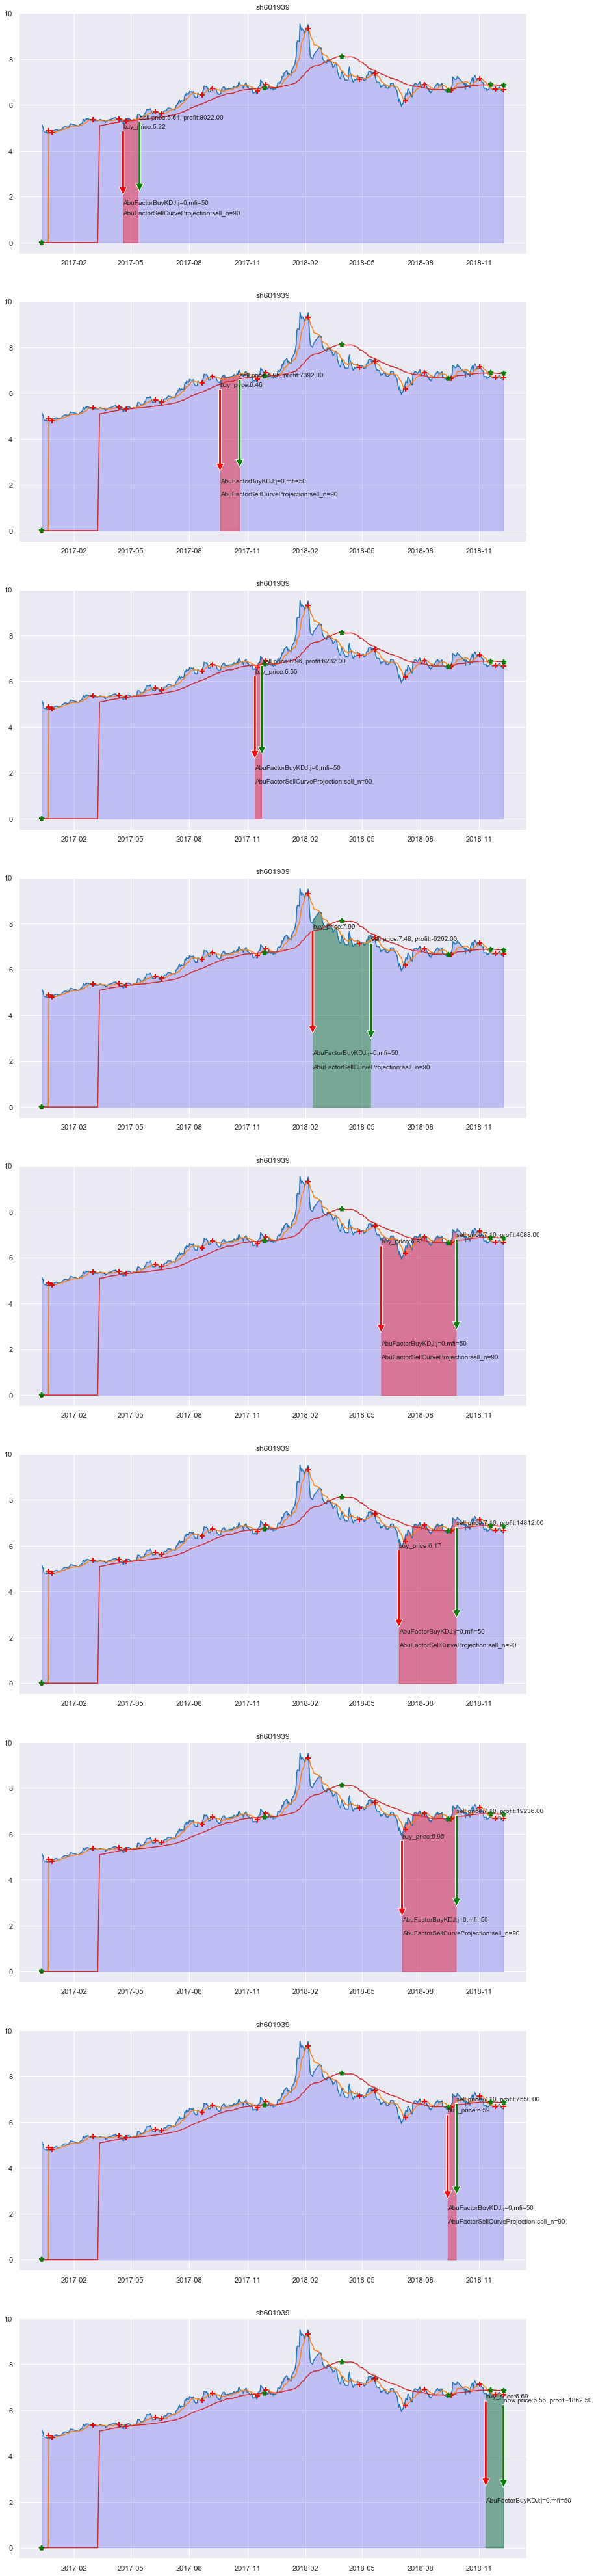

In [60]:
    orders_pd, action_pd, _ = ABuTradeProxy.trade_summary(abu_worker.orders, kl_pd, draw=True,
        ext_list = factor_summary)

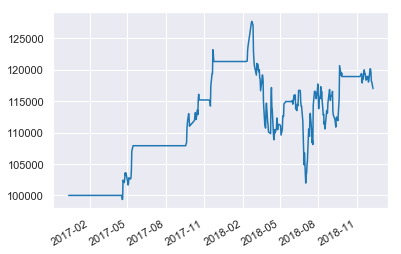

In [36]:
    ABuTradeExecute.apply_action_to_capital(capital, action_pd, kl_pd_manager)
    capital.capital_pd.capital_blance.plot()
    plt.show()